In [1]:
import numpy as np
from PIL import Image
import os

In [2]:
from datetime import datetime
from tqdm import tqdm
import numpy as np
import random, os, sys, torch, cv2, warnings
from glob import glob
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

prj_dir = os.path.dirname('/scratch/network/mk8574/change_detection_challenge/baseline_lks/')

from modules.utils import load_yaml, save_yaml, get_logger
from modules.scalers import get_image_scaler
from modules.datasets import SegDataset
from models.utils import get_model


def colorize_mask(mask, colors):
    # Colorize the mask based on the provided colors
    # `colors` should be a dictionary mapping each class to a BGR color
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for cls, color in colors.items():
        colored_mask[mask == cls] = color
    
    return colored_mask

def overlay_mask_on_image(image, mask, alpha=0.5):
    # Overlay the mask on the image
    overlay = cv2.addWeighted(image, alpha, mask, 1 - alpha, 0)
    return overlay

# Define colors for each class in BGR format
class_colors = {
    0: [0, 0, 0],        # Class 0: Black
    1: [255, 0, 0],      # Class 1: Blue
    2: [0, 255, 0],      # Class 2: Green
    3: [0, 0, 255],      # Class 3: Red
}

/home/mk8574/.conda/envs/mk8574_3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def predict_image(img_id = '2015_DMG_1LB_000066'):

    config = load_yaml(os.path.join(prj_dir, 'config', 'predict.yaml'))
    train_config = load_yaml(os.path.join(prj_dir, 'results', 'train', config['train_serial'], 'train.yaml'))

    #! Set predict serial
    pred_serial = config['train_serial'] + '_' + datetime.now().strftime("%Y%m%d_%H%M%S")

    # Set random seed, deterministic
    torch.cuda.manual_seed(train_config['seed'])
    torch.manual_seed(train_config['seed'])
    np.random.seed(train_config['seed'])
    random.seed(train_config['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set device(GPU/CPU)
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config['gpu_num'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create train result directory and set logger
    pred_result_dir = os.path.join(prj_dir, 'results', 'pred', pred_serial)
    pred_result_dir_mask = os.path.join(prj_dir, 'results', 'pred', pred_serial, 'mask')
    os.makedirs(pred_result_dir, exist_ok=True)
    os.makedirs(pred_result_dir_mask, exist_ok=True)


    # Load architecture
    model = get_model(model_str=train_config['architecture'])
    model = model(
                classes=train_config['n_classes'],
                encoder_name=train_config['encoder'],
                encoder_weights=train_config['encoder_weight'],
                activation=train_config['activation']).to(device)

    #! Load weight
    check_point_path = os.path.join(prj_dir, 'results', 'train', config['train_serial'], 'model.pt')
    check_point = torch.load(check_point_path)
    model.load_state_dict(check_point['model'])

    base_url = os.path.join("/scratch/network/mk8574/change_detection_challenge/data/train")
    filename = img_id + ".png"
    orig_img = cv2.imread(os.path.join(base_url, 'x', filename), cv2.IMREAD_COLOR)
    orig_size = orig_img.shape

    x = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, [train_config['input_width'], train_config['input_height']])
    x = get_image_scaler(train_config['scaler'])(x)
    x = torch.tensor(x.transpose(2, 0, 1)).unsqueeze(0)

    model.eval()

    with torch.no_grad():
        x = x.to(device, dtype=torch.float)
        y_pred = model(x)
        y_pred_argmax = y_pred.argmax(1).squeeze(0).cpu().numpy().astype(np.uint8)
        predicted_mask = cv2.resize(y_pred_argmax, orig_img.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)

    gt_mask_path = os.path.join(base_url, 'y', filename) # Define `ground_truth_dir` appropriately
    gt_mask = cv2.imread(gt_mask_path, 0) # 0 for grayscale
    
    # If `x` is a tensor, convert it to a numpy array and adjust channels
    if torch.is_tensor(x):
        # Assuming x is a single image, but check if it's a batch
        if len(x.shape) == 4:
            # If it's a batch, take the first image
            x = x[0]

        # Convert to numpy and change channel order
        x = x.permute(1, 2, 0).cpu().numpy()

    # Display the images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    predicted_img = overlay_mask_on_image(orig_img, colorize_mask(predicted_mask, class_colors), alpha=0.5)
    plt.imshow(predicted_img)
    plt.title('Predicted Segmentation')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    gt_img = overlay_mask_on_image(orig_img, colorize_mask(gt_mask, class_colors), alpha=0.5)
    plt.imshow(gt_img)
    # plt.imshow(gt_mask)
    plt.title('Ground Truth Segmentation')
    plt.axis('off')

    plt.show()

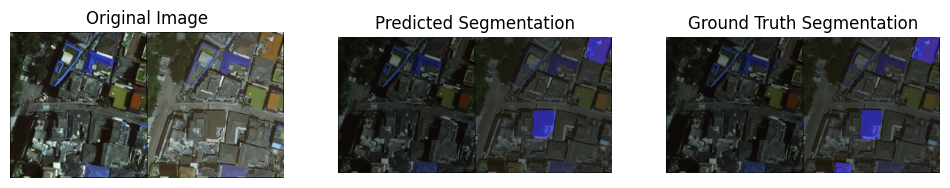

In [7]:
predict_image('2015_DMG_1LB_000066')